#1.Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-02-09 23:09:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2023-02-09 23:09:11 (6.10 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [4]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [5]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [6]:
# Create function to label windowed data
def get_labelled_windows(x, horizon):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [7]:
def make_windows(x, window_size, horizon):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

## Univariant scaled model

Model 1: Dense model (window = 7, horizon = 1)

In [8]:
import numpy as np

In [9]:
WINDOW_SIZE = 7
HORIZON = 1

In [10]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [9]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of winodws and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_labels

array([[ 123.033     ],
       [ 124.049     ],
       [ 125.96116   ],
       ...,
       [9335.75240233],
       [9226.48582088],
       [8794.35864452]])

In [ ]:
#Scaling the data
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

In [ ]:
#scale the train_windows column
scaler.fit(train_windows)
scaled_train_windows = scaler.transform(train_windows)
scaled_train_windows = np.squeeze(scaled_train_windows)

In [ ]:
#scale the labels column
scaler.fit(train_labels)
scaled_train_labels = scaler.transform(train_labels)
scaled_train_labels = np.squeeze(scaled_train_labels)

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

#1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")# linear activation is the same as having no activation               
], name="model_1_dense") # name our model so we can save it

#2.Compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

#3. Fit the model
model_1.fit(x=scaled_train_windows,
            y=scaled_train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 2s 52ms/step - loss: 0.0373 - mae: 0.0373 - mse: 0.0052 - val_loss: 1019.1144 - val_mae: 1019.1144 - val_mse: 3502903.7500
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0126 - mae: 0.0126 - mse: 5.1688e-04 - val_loss: 1070.8154 - val_mae: 1070.8154 - val_mse: 3468113.7500
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0095 - mae: 0.0095 - mse: 4.4707e-04 - val_loss: 1087.7621 - val_mae: 1087.7621 - val_mse: 3444888.7500
Epoch 4/100
18/18 [==============================] - 1s 33ms/step - loss: 0.0093 - mae: 0.0093 - mse: 4.3922e-04 - val_loss: 981.0110 - val_mae: 981.0110 - val_mse: 3022545.5000
Epoch 5/100
18/18 [==============================] - 1s 33ms/step - loss: 0.0089 - mae: 0.0089 - mse: 4.1317e-04 - val_loss: 955.6453 - val_mae: 955.6453 - val_mse: 2864629.0000
Epoch 6/100
18/18 [==============================] - 1s 34ms/step - loss: 0.0086 - mae: 0.0086 - mse: 3.8834e-

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 580.0608 - mae: 580.0608 - mse: 1189155.3750


[580.060791015625, 580.060791015625, 1189155.375]

In [ ]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.5628 - mae: 568.5628 - mse: 1173733.0000


[568.5628051757812, 568.5628051757812, 1173733.0]

In [ ]:
#Predict the data
model_1_preds = tf.squeeze(model_1.predict(test_windows))

18/18 [==============================] - 0s 1ms/step


## Multivariante

In [71]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [72]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [73]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [74]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


In [ ]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

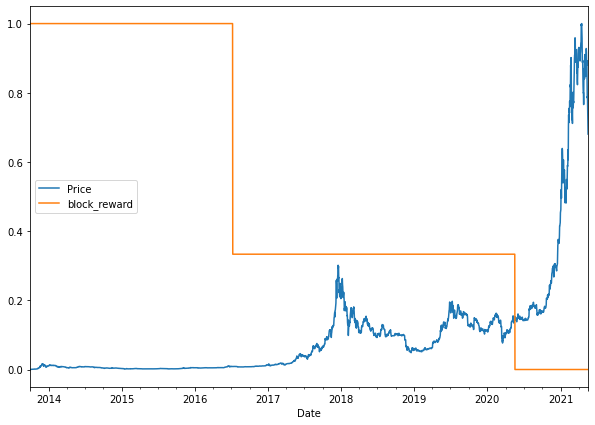

In [ ]:
scaled_price_block_df.plot(figsize=(10, 7));

In [104]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [78]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [79]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [80]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [87]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)                          
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 [==============================] - 1s 49ms/step - loss: 0.0514 - val_loss: 0.0514
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0867
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0918
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0858
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0838
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0773
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0817
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0774
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0811
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0814
Epoch 11

In [ ]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 0.0748


0.07477851957082748

In [ ]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0514


0.05141492560505867

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.17084704, 0.17078666, 0.1696672 , 0.16792355, 0.16769044,
       0.16453283, 0.16271336, 0.16369693, 0.16173606, 0.1604328 ],
      dtype=float32)>

# 2.Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
You can download the Bitcoin historical data for free from coindesk.com/price/bitcoin and clicking "Export Data" -> "CSV".

##Get data

## Importing time series with pandas

In [12]:
import numpy as np

In [2]:
import pandas as pd
df = pd.read_csv("/content/sample_data/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [4]:
bitcoin_prices.shape

(3065, 1)

In [5]:
# Get bitcoin date array
timesteps_upd = bitcoin_prices.index.to_numpy()
prices_upd = bitcoin_prices["Price"].to_numpy()

In [6]:
WINDOWS=7
HORIZON=1

In [15]:
full_windows , full_labels = make_windows(prices_upd,WINDOWS,HORIZON)
len(full_windows), len(full_labels)

(3058, 3058)

In [16]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2446, 612, 2446, 612)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

#1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")# linear activation is the same as having no activation               
], name="model_1_dense") # name our model so we can save it

#2.Compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

#3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels))

Epoch 1/100
20/20 [==============================] - 1s 10ms/step - loss: 1907.5054 - mae: 1907.5054 - mse: 20197806.0000 - val_loss: 3728.9138 - val_mae: 3728.9138 - val_mse: 19861292.0000
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 543.6330 - mae: 543.6330 - mse: 1622659.3750 - val_loss: 2131.1101 - val_mae: 2131.1101 - val_mse: 7643465.5000
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 429.2564 - mae: 429.2564 - mse: 1142465.0000 - val_loss: 1515.2378 - val_mae: 1515.2378 - val_mse: 4373536.5000
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 406.9932 - mae: 406.9932 - mse: 1033301.1875 - val_loss: 1330.8519 - val_mae: 1330.8519 - val_mse: 3544820.2500
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 391.2836 - mae: 391.2836 - mse: 976431.9375 - val_loss: 1525.9838 - val_mae: 1525.9838 - val_mse: 4357221.0000
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss

In [ ]:
# Evaluating the model 
model_1.evaluate(test_windows , test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1082.0477 - mae: 1082.0477 - mse: 2202333.7500


[1082.0477294921875, 1082.0477294921875, 2202333.75]

#3.For most of our models we used WINDOW_SIZE=7, but is there a better window size?
Setup a series of experiments to find whether or not there's a better window size.
For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.

In [ ]:
for i in range(2,12):
  HORIZON = 1 
  WINDOW_SIZE = i

  # Making window and labels 
  full_windows , full_labels = make_windows(prices_upd, window_size= WINDOW_SIZE , horizon= HORIZON)
  

  # Splitting the data in train and test
  train_windows ,  test_windows ,train_labels,  test_labels = make_train_test_splits(full_windows , full_labels)


  #Construct model
  model = tf.keras.Sequential([
      layers.Dense(128, activation="relu",input_shape=(WINDOW_SIZE,)),
      layers.Dense(HORIZON, activation="linear")# linear activation is the same as having no activation               
  ])

  # Compiling and fitting the model 
  model.compile(loss = 'mae' , optimizer = 'adam' , metrics = 'mae')

  model.fit(train_windows , train_labels , 
            epochs = 100 , verbose = 0 , 
            batch_size = 128 , 
            validation_data = (test_windows , test_labels))
  

  # Making predictions 
  preds_ = model.predict(test_windows)
  y_preds = tf.squeeze(preds_)

  
  # Casting the values to float32 
  y_true = tf.cast(test_labels , tf.float32)
  y_pred = tf.cast(y_preds , tf.float32)


  # Calculate the metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true , y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true , y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true , y_pred)
  
  # For longer horizons 
  if mae.ndim > 0:
    mae = tf.reduce_sum(mae)
    mse = tf.reduce_sum(mse)
    rmse = tf.reduce_sum(rmse)
    mape = tf.reduce_sum(mape)

  print(f'The model result for the model with Horizon {HORIZON} and window_size {i} is Mae:{mae.numpy()},MSE:{mse.numpy()},RMSE: {rmse.numpy()},MAPE: {mape.numpy()}')

  

20/20 [==============================] - 0s 2ms/step
The model result for the model with Horizon 1 and window_size 2 is Mae:9502211.0,MSE:229278711808.0,RMSE: 11548150.0,MAPE: 32327.712890625
20/20 [==============================] - 0s 1ms/step
The model result for the model with Horizon 1 and window_size 3 is Mae:9546813.0,MSE:231392526336.0,RMSE: 11608854.0,MAPE: 32609.529296875
20/20 [==============================] - 0s 2ms/step
The model result for the model with Horizon 1 and window_size 4 is Mae:9475824.0,MSE:227998351360.0,RMSE: 11510343.0,MAPE: 32138.587890625
20/20 [==============================] - 0s 2ms/step
The model result for the model with Horizon 1 and window_size 5 is Mae:9410705.0,MSE:225205600256.0,RMSE: 11416940.0,MAPE: 31703.291015625
20/20 [==============================] - 0s 2ms/step
The model result for the model with Horizon 1 and window_size 6 is Mae:9441512.0,MSE:226725068800.0,RMSE: 11463586.0,MAPE: 31928.732421875
20/20 [==============================] -

#4.Create a windowed dataset just like the ones we used for model_1 using tf.keras.preprocessing.timeseries_dataset_from_array() and retrain model_1 using the recreated dataset.

In [13]:
WINDOWS=7

In [11]:
import tensorflow as tf

In [14]:
dataset = tf.keras.utils.timeseries_dataset_from_array(
    prices, prices, sequence_length = WINDOWS, sequence_stride = HORIZON, 
    batch_size = 128
)

In [15]:
len(dataset)

22

In [16]:
split = int(0.8 * len(prices))

windows_dataset = tf.keras.utils.timeseries_dataset_from_array(prices, prices[WINDOWS:],
                                             sequence_length=WINDOWS, batch_size=len(prices)).unbatch()

train_windows_ds = windows_dataset.take(split).batch(128)
test_windows_ds = windows_dataset.skip(split).batch(128)

In [17]:
train_windows_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [18]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(7,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(HORIZON, activation='linear')
], name="model_1")

model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_1.fit(train_windows_ds,
            epochs=100,
            validation_data=test_windows_ds)

model_1.evaluate(test_windows_ds)

Epoch 1/100
18/18 [==============================] - 2s 42ms/step - loss: 364.4853 - mae: 364.4853 - val_loss: 1286.9979 - val_mae: 1286.9979
Epoch 2/100
18/18 [==============================] - 1s 28ms/step - loss: 330.9420 - mae: 330.9420 - val_loss: 1726.8981 - val_mae: 1726.8981
Epoch 3/100
18/18 [==============================] - 1s 42ms/step - loss: 217.4858 - mae: 217.4858 - val_loss: 1329.7854 - val_mae: 1329.7854
Epoch 4/100
18/18 [==============================] - 1s 46ms/step - loss: 197.2953 - mae: 197.2953 - val_loss: 1255.1547 - val_mae: 1255.1547
Epoch 5/100
18/18 [==============================] - 1s 47ms/step - loss: 187.4543 - mae: 187.4543 - val_loss: 1127.5912 - val_mae: 1127.5912
Epoch 6/100
18/18 [==============================] - 1s 26ms/step - loss: 182.2507 - mae: 182.2507 - val_loss: 1078.4264 - val_mae: 1078.4264
Epoch 7/100
18/18 [==============================] - 1s 25ms/step - loss: 176.9580 - mae: 176.9580 - val_loss: 1022.9172 - val_mae: 1022.9172
Epoch 

[843.1676635742188, 843.1676025390625]

In [57]:
## Another Method.
split = int(0.8 * len(prices))

features_prices_train = prices[:split+WINDOWS-1]
features_prices_test = prices[split:-1]

labels_prices_train = prices[WINDOWS:split+WINDOWS]
labels_prices_test = prices[split+WINDOWS:]

train_windows_ds = tf.keras.utils.timeseries_dataset_from_array(features_prices_train, labels_prices_train,
                                             sequence_length=WINDOWS).prefetch(tf.data.AUTOTUNE)
test_windows_ds = tf.keras.utils.timeseries_dataset_from_array(features_prices_test, labels_prices_test,
                                             sequence_length=WINDOWS).prefetch(tf.data.AUTOTUNE)

In [59]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(7,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(HORIZON, activation='linear')
], name="model_1")

model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_1.fit(train_windows_ds,
            steps_per_epoch = len(train_windows_ds),
            epochs=100,
            validation_data=test_windows_ds,
            validation_steps = len(test_windows_ds))

model_1.evaluate(test_windows_ds)

Epoch 1/100
18/18 [==============================] - 1s 56ms/step - loss: 1482.6042 - mae: 1482.6042 - val_loss: 3024.3386 - val_mae: 3024.3386
Epoch 2/100
18/18 [==============================] - 1s 58ms/step - loss: 784.7448 - mae: 784.7448 - val_loss: 1952.0222 - val_mae: 1952.0222
Epoch 3/100
18/18 [==============================] - 1s 77ms/step - loss: 544.9056 - mae: 544.9056 - val_loss: 1421.1597 - val_mae: 1421.1597
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 586.6493 - mae: 586.6493 - val_loss: 1228.4379 - val_mae: 1228.4379
Epoch 5/100
18/18 [==============================] - 0s 24ms/step - loss: 641.3180 - mae: 641.3180 - val_loss: 1759.3333 - val_mae: 1759.3333
Epoch 6/100
18/18 [==============================] - 0s 23ms/step - loss: 544.3277 - mae: 544.3277 - val_loss: 1198.6188 - val_mae: 1198.6188
Epoch 7/100
18/18 [==============================] - 0s 22ms/step - loss: 607.0646 - mae: 607.0646 - val_loss: 1659.5762 - val_mae: 1659.5762
Epoc

[942.1008911132812, 942.1008911132812]

#5.For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.


*   Are there any other features you think you could add?
*   If so, try it out, how do these affect the model?

In [65]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [66]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [68]:
df.index.year

Int64Index([2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='Date', length=2787)

In [69]:
df['year'] = df.index.year
df.head(10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),year
Date,,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349,2013
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383,2013
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833,2013
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816,2013
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566,2013
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450,2013
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199,2013
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066,2013
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266,2013


In [88]:
bitcoin_prices_windowed

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654990,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,25,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,25,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,25,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


In [105]:
bitcoin_prices_windowed['year'] = bitcoin_prices_windowed.index.year

In [106]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,year
Date,,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,2013
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,2013
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,2013
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,2013


In [108]:
year_dummies = pd.get_dummies(bitcoin_prices_windowed.year)

In [111]:
bitcoin_price_year =pd.concat([bitcoin_prices_windowed, year_dummies], axis=1)

In [112]:
bitcoin_price_year.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,year,2013,2014,2015,2016,2017,2018,2019,2020,2021
Date,,,,,,,,,,,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,1,0,0,0,0,0,0,0,0
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,2013,1,0,0,0,0,0,0,0,0
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,2013,1,0,0,0,0,0,0,0,0
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,2013,1,0,0,0,0,0,0,0,0
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,2013,1,0,0,0,0,0,0,0,0


In [115]:
# Create X (windows) and y (horizons) features
X = bitcoin_price_year.dropna().drop(["Price","year"], axis=1).astype(np.float32)
y = bitcoin_price_year.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,2013,2014,2015,2016,2017,2018,2019,2020,2021
Date,,,,,,,,,,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [119]:
from tensorflow.keras import layers

In [121]:
tf.random.set_seed(42)

# Make multivariate time series model
model_multi = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)                          
], name="dense_multivariate_year")

# Compile
model_multi.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_multi.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test))

Epoch 1/100
18/18 [==============================] - 0s 9ms/step - loss: 1255.8031 - val_loss: 1928.6373
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 344.4625 - val_loss: 1873.4839
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 231.7240 - val_loss: 1327.1538
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 205.6770 - val_loss: 1098.3813
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 196.0177 - val_loss: 1105.9113
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 187.9445 - val_loss: 1042.5577
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 183.1784 - val_loss: 1022.6290
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 176.8452 - val_loss: 994.9822
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 171.1727 - val_loss: 963.8833
Epoch 10/100
18/18 [==============================] - 0s 3ms/step

In [122]:
model_multi.summary()

Model: "dense_multivariate_year"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               2304      
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


In [123]:
# Evaluate multivariate model
model_multi.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 603.0583


603.058349609375

#6.Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.

In [125]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [126]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned: 
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models 

In [127]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 544: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 644: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 387: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 487: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 263: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 363: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 170: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 444: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 544: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing 

In [128]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [129]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 365ms/step
CPU times: user 1.25 s, sys: 14.4 ms, total: 1.27 s
Wall time: 1.84 s


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8845.087 ,  8756.784 ,  9050.215 , ..., 50303.33  , 49460.88  ,
        46337.86  ],
       [ 8812.193 ,  8802.857 ,  9046.971 , ..., 50059.664 , 48122.918 ,
        46123.855 ],
       [ 8816.242 ,  8809.026 ,  9053.8545, ..., 50040.047 , 48034.383 ,
        45862.523 ],
       ...,
       [ 8770.615 ,  8733.284 ,  9110.194 , ..., 49860.367 , 49229.613 ,
        46374.348 ],
       [ 8781.471 ,  8753.542 ,  9070.724 , ..., 49961.84  , 48253.36  ,
        46310.344 ],
       [ 8829.712 ,  8819.487 ,  9081.994 , ..., 49942.99  , 49344.082 ,
        45800.926 ]], dtype=float32)>

In [130]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]  

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8802.183, 8781.465, 9075.251, 8745.42 , 8751.88 , 8745.448,
       8658.417, 8502.507, 8467.689, 8533.031], dtype=float32)>

In [134]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [132]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [135]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 566.2802,
 'mse': 1146966.9,
 'rmse': 1070.9655,
 'mape': 2.5538223,
 'mase': 0.99479747}